In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Lasso
import scipy.stats
import time
from imageio import imread

mpl.style.use("seaborn-darkgrid")
mpl.rcParams["image.cmap"] = "gnuplot2"
mpl.rcParams['figure.figsize'] = [8.0, 6.0]

np.random.seed(1942)

# 1. Linear Regression on Generic Data

## 1.1 The Franke Funtion, with noise

In [28]:
def Franke(x, y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def FrankeNoise(x, y, sigma=0.1):
    return Franke(x, y) + np.random.normal(0, sigma, np.shape(x))

# K-fold Class

In [3]:
class KFold_iterator:
    def __init__(self, input_dim, nr_splits=5):
        self.input_dim = input_dim
        self.nr_splits = nr_splits
        self.nr_iters_done = 0
        self.index_data = self.shuffle_split()

    def __iter__(self):
        return self

    def __next__(self):
        if self.nr_iters_done < self.nr_splits:
            self.iter = (np.concatenate(self.index_data[1:]), self.index_data[0])
            self.index_data = self.index_data[1:] + [self.index_data[0]]
            self.nr_iters_done += 1
            return self.iter
        else:
            raise StopIteration

    def shuffle_split(self):
        indexes = np.arange(self.input_dim)
        np.random.shuffle(indexes)
        return np.array_split(indexes, self.nr_splits)

# Regression Class

In [7]:
class Regression:
    def __init__(self):
        pass

    def generate_generic_data(self, x, y, func):
        self.xshape, self.yshape = len(x), len(y)
        print("asdf", x.shape, y.shape)
        x_mesh, y_mesh = np.meshgrid(x, y)
        print(x_mesh.shape, y_mesh.shape)
        self.set_data(x_mesh, y_mesh, func(x_mesh, y_mesh))

    def load_matrix_data(self, A):
        self.yshape, self.xshape = A.shape
        x = np.linspace(0, 1, self.xshape); y = np.linspace(0, 1, self.yshape)
        x_mesh, y_mesh = np.meshgrid(x, y)
        self.set_data(x_mesh, y_mesh, A)
        
    def set_data(self, x_mesh, y_mesh, f):
        print("f:", f.shape)
        self.f = f
        self.x_mesh, self.y_mesh = x_mesh, y_mesh
        self.x_flat, self.y_flat, self.f_flat = self.x_mesh.flatten(), self.y_mesh.flatten(), self.f.flatten()
        self.nr_datapoints = len(self.x_flat)

    def get_X(self, x, y, poly_order):
        self.poly_order = poly_order
        nr_terms = ((poly_order + 1)*(poly_order + 2))//2
        X = np.zeros((np.size(x), nr_terms))
        X[:,0] = 1

        i = 0
        for ix in range(poly_order+1):
            for iy in range(poly_order+1):
                if 0 < ix + iy < poly_order+1:
                    i += 1
                    X[:,i] = x**ix*y**iy
        return X

    def apply_model(self, beta, x, y, poly_order):
        i = 0
        result = beta[0]
        for ix in range(poly_order+1):
            for iy in range(poly_order+1):
                if 0 < ix + iy < poly_order+1:
                    i += 1
                    result += beta[i]*x**ix*y**iy
        return result

    def get_beta(self, X, f, solver="OLS", lamda=0):
        XT = X.T
        if solver=="OLS":
            beta = np.linalg.inv(XT@X)@XT@f
        elif solver=="Ridge":
            print(lamda)
            beta = np.linalg.inv(XT@X + np.identity(X.shape[1])*lamda)@XT@f
        elif solver=="Lasso":
            print("TBA")
        else:
            print("Dust")
            raise NotImplementedError
        return beta
    
    def solveCoefficients(self, poly_order=5, solver="OLS", lamda=1e-4):
        X = self.get_X(self.x_flat, self.y_flat, poly_order)
        beta = self.get_beta(X, self.f_flat, solver=solver, lamda=lamda)
        return beta

    def solveTrainTest(self, poly_order=5, test_fraction=0.25, solver="OLS", lamda=1e-4):
        x_flat, y_flat, f_flat = self.x_flat, self.y_flat, self.f_flat
        x_train, x_test, y_train, y_test, output_train, outut_test = train_test_split(x_flat, y_flat, f_flat, test_size=test_fraction)
        X = self.get_X(x_train, y_train, poly_order)
        beta = self.get_beta(X, output_train, solver=solver, lamda=lamda)
        output_test_pred = self.apply_model(beta, x_test, y_test, poly_order)
        return output_test, output_test_pred
        
    def solveKFold(self, K=5, solver="OLS", poly_order=5, lamda=1e-4):
        x_flat, y_flat, f_flat = self.x_flat, self.y_flat, self.f_flat
        output_pred = np.zeros(self.nr_datapoints)
        kf = KFold_iterator(self.nr_datapoints, K)
        for train_index, test_index in kf:
            x_train, x_test, y_train, y_test = x_flat[train_index], x_flat[test_index], y_flat[train_index], y_flat[test_index]
            output_train, output_test = f_flat[train_index], f_flat[test_index]
            X = self.get_X(x_train, y_train, poly_order)
            beta = self.get_beta(X, output_train, solver=solver, lamda=lamda)
            output_test_pred = self.apply_model(beta, x_test, y_test, poly_order)
            output_pred[test_index] = output_test_pred
            print("yo")
        output_pred_stacked = np.zeros((self.yshape, self.xshape))
        for i in range(self.yshape):
            output_pred_stacked[i] = output_pred[i*self.xshape : (i+1)*self.xshape]
        return output_pred_stacked

In [ ]:
terrain1 = imread("../input_data/SRTM_data_Norway_1.tif")

reg = Regression()

reg.load_matrix_data(terrain1)
data_pred = reg.solveKFold(K=10, poly_order=10, solver="Ridge", lamda=1e-4)

print(terrain1.shape)
plt.figure(); plt.imshow(terrain1);

plt.figure(); plt.imshow(data_pred);

In [ ]:
terrain1 = imread("../input_data/SRTM_data_Norway_1.tif")

reg = Regression()

reg.load_matrix_data(terrain1)
beta = reg.solveCoefficients(poly_order=10, solver="Ridge", lamda=1e-4)
data_pred = reg.apply_model(beta, reg.x_mesh, reg.y_mesh, poly_order=10)

print(terrain1.shape)
plt.figure(); plt.imshow(terrain1);

plt.figure(); plt.imshow(data_pred);

In [ ]:
x, y = np.linspace(0, 1, 101), np.linspace(0, 1, 201)
x_mesh, y_mesh = np.meshgrid(x, y)
input_data = FrankeNoise(x_mesh, y_mesh)
reg = Regression()
#reg.generate_generic_data(x, y, FrankeNoise)
plt.imshow(input_data)
reg.load_matrix_data(input_data)
data_pred = reg.solveKFold(K=10, poly_order=15, solver="Ridge", lamda=1e-5)
plt.figure(); plt.imshow(data_pred)

f: (3601, 1801)
1e-05
yo
1e-05
yo
1e-05
yo
1e-05
yo
1e-05
yo
1e-05
yo
1e-05
yo
1e-05
yo
1e-05
yo
1e-05
yo
1e-05
yo
1e-05
yo
1e-05
yo
1e-05
yo
1e-05
yo
1e-05
yo
1e-05
yo
1e-05
yo
1e-05
yo
1e-05
yo


(3601, 1801)

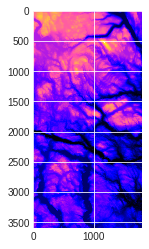

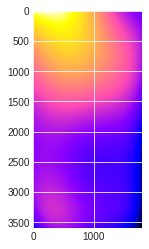

In [9]:
terrain1 = imread("../input_data/SRTM_data_Norway_1.tif")
#x, y = np.linspace(0, 1, 101), np.linspace(0, 1, 201)
#x_mesh, y_mesh = np.meshgrid(x, y)
plt.imshow(terrain1)
reg = Regression()
reg.load_matrix_data(terrain1)
data_pred = reg.solveKFold(K=20, poly_order=5, solver="Ridge", lamda=1e-5)
plt.figure()
plt.imshow(data_pred)
#beta = reg.solveCoefficients(poly_order=5)
#data_pred = reg.apply_model(beta, reg.x_mesh, reg.y_mesh, poly_order=5)
terrain1.shape

In [ ]:
plt.plot(data_pred[3200])

In [ ]:
xshape, yshape = 101, 201
nr_datapoints = xshape*yshape
reg = Regression()
reg.generate_generic_data(np.linspace(0, 1, xshape), np.linspace(0, 1, yshape), FrankeNoise)
#beta = reg.solveCoefficients()
#data_pred = reg.apply_model(beta, reg.x_mesh, reg.y_mesh, poly_order=5)
data_pred = reg.solveKFold(K=5, poly_order=5, solver="Ridge", lamda=1e-4)
plt.pcolormesh(reg.x_mesh, reg.y_mesh, data_pred);
plt.figure();
plt.pcolormesh(reg.x_mesh, reg.y_mesh, reg.f);
reg.x_mesh.shape, reg.y_mesh.shape, data_pred.shape

In [ ]:
nr_points_per_dim = 201
nr_datapoints = nr_points_per_dim**2

### 1.1.1 Plotting the Franke Function, with and without noise

In [ ]:
x = np.linspace(0, 1, nr_points_per_dim)
y = np.linspace(0, 1, nr_points_per_dim)
#x = np.random.uniform(0, 1, nr_points_per_dim)
#y = np.random.uniform(0, 1, nr_points_per_dim)
x_, y_ = np.meshgrid(x, y)

x_flat = x_.flatten()
y_flat = y_.flatten()

data = FrankeNoise(x_, y_,sigma=1)
f = data.flatten()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
plt1 = ax1.pcolormesh(x_, y_, FrankeNoise(x_,y_));
fig.colorbar(plt1, ax=ax1);

plt2 = ax2.pcolormesh(x_, y_, Franke(x_, y_))
fig.colorbar(plt2, ax=ax2);

## 1.2 Setting up the design matrix and model

In [ ]:
poly_order = 5

### 1.2.1 The design matrix, X

In [ ]:
def make_X(x_flat, y_flat, poly_order):
    nr_terms = ((poly_order + 1)*(poly_order + 2))//2
    X = np.zeros((np.size(x_flat), nr_terms))
    X[:,0] = 1

    i = 0
    for ix in range(poly_order+1):
        for iy in range(poly_order+1):
            if 0 < ix + iy < poly_order+1:
                i += 1
                X[:,i] = x_flat**ix*y_flat**iy
    return X

### 1.2.2 The Model

In [ ]:
def Model(beta, x, y, poly_order):
    i = 0
    result = beta[0]
    for ix in range(poly_order+1):
        for iy in range(poly_order+1):
            if 0 < ix + iy < poly_order+1:
                i += 1
                result += beta[i]*x**ix*y**iy
    return result

## 1.3 Predicting model from noisy data with Linear Regression using OLS

In [ ]:
X = make_X(x_flat, y_flat, poly_order)
beta = np.linalg.inv(X.T@X)@X.T@f
data_pred = Model(beta, x_, y_, poly_order)

## 1.4 Results

In [ ]:
plt.figure(figsize=(8,6))
plt.pcolormesh(x_, y_, data_pred)
plt.colorbar();

## 1.4.1 Score values

In [ ]:
print("MSE Score = ", MSE(data, data_pred))
print("RRMSE Score = ", np.sqrt(MSE(data, data_pred))/np.mean(data))
print("MSE Score (vs true model) =", MSE(Franke(x_, y_), data_pred))

In [ ]:
print("R2 Score = ", r2_score(data, data_pred))

## 1.4.2 Analysing the noise

In [ ]:
noise_pred = data - data_pred

In [ ]:
plt.figure(figsize = (8, 6))
plt.pcolormesh(noise_pred)
plt.colorbar();

In [ ]:
plt.hist(noise_pred.flatten(), bins=40, color="navy");

### 1.4.3 Probability Plot - Confirming normal distribution of noise

In [ ]:
(x, y), (slope, intercept, r) = scipy.stats.probplot(noise_pred.flatten());

plt.figure(figsize = (8,6))
plt.plot(x, y, color="navy");
plt.plot(x, intercept + x*slope, ls="--", c="crimson")
r

## 1.5 Round 2 - Running the model for different polynomial degrees

In [ ]:
err_list = []
err_list_truemodel = []
nr_poly_orders = 16
poly_orders = np.arange(1, nr_poly_orders + 1)

fig, ax = plt.subplots(nr_poly_orders//4, 4, figsize=(16, 4*nr_poly_orders//4))

for i, poly_order in enumerate(poly_orders):
    t0 = time.time()
    X = make_X(x_flat, y_flat, poly_order)
    beta = np.linalg.inv(X.T@X)@X.T@f
    #print(i, beta)
    data_pred = Model(beta, x_, y_, poly_order)
    print(time.time() - t0)
    #plt.figure(figsize=(8,8))
    ax[i//4, i%4].pcolormesh(data_pred)
    ax[i//4, i%4].set_title(MSE(data_pred, data))
    err_list.append(np.sum(np.abs(data - data_pred)))
    err_list_truemodel.append(np.sum(np.abs(Franke(x_, y_) - data_pred)))    

In [ ]:
plt.plot(np.log(err_list[:9]));

In [ ]:
plt.plot(np.log(err_list_truemodel[:9]));

# 2 Ridge Regression

In [ ]:
lamda = 1e-8

err_list = []
err_list_truemodel = []
nr_poly_orders = 4*2
poly_orders = np.arange(1, nr_poly_orders + 1)

fig, ax = plt.subplots(nr_poly_orders//4, 4, figsize=(16, 4*nr_poly_orders//4))

for i, poly_order in enumerate(poly_orders):
    t0 = time.time()
    X = make_X(x_flat, y_flat, poly_order)
    beta = np.linalg.inv(X.T@X + np.identity(X.shape[1])*lamda)@X.T@f
    #print(i, beta)
    data_pred = Model(beta, x_, y_, poly_order)
    print(time.time() - t0)
    #plt.figure(figsize=(8,8))
    ax[i//4, i%4].pcolormesh(data_pred)
    ax[i//4, i%4].set_title(MSE(data_pred, data))
    err_list.append(np.sum(np.abs(data - data_pred)))
    err_list_truemodel.append(np.sum(np.abs(Franke(x_, y_) - data_pred)))

In [ ]:
plt.plot(np.log(err_list));

In [ ]:
plt.plot(np.log(err_list_truemodel));

# Lasso regression

In [33]:
lamda = 1e-5

err_list = []
err_list_truemodel = []
lower_poly_order = 1
nr_poly_orders = 4
poly_orders = np.arange(lower_poly_order, lower_poly_order+nr_poly_orders)

fig, ax = plt.subplots(nr_poly_orders//4, 4, figsize=(16, 4*nr_poly_orders//4))

for i, poly_order in enumerate(poly_orders):
    print('i',i)
    t0 = time.time()
    X = make_X(x_flat, y_flat, poly_order)
    
    _lasso = Lasso(alpha=lamda,max_iter=1e3,tol=0.001)
    clf = _lasso.fit(X,f)
    data_pred = Model(clf.coef_,x_,y_,poly_order)
    print('beta shape',clf.coef_.shape)
 #   data_pred = X*clf.coef_
#    print(data_pred.shape)

    print(time.time() - t0)

    ax[i//4, i%4].pcolormesh(data_pred)
    ax[i//4, i%4].set_title(MSE(data_pred, data))
    
    err_list.append(np.sum(np.abs(data - data_pred)))
    err_list_truemodel.append(np.sum(np.abs(Franke(x_, y_) - data_pred)))

# 3. Train-test split

In [ ]:
poly_order = 5

input_ = np.zeros((nr_datapoints, 2))
input_[:,0] = x_flat
input_[:,1] = y_flat

In [ ]:
input_train, input_test, output_train, output_test = train_test_split(input_, f, test_size = 0.3)

In [ ]:
X = make_X(input_train[:,0], input_train[:,1], poly_order)
beta = np.linalg.inv(X.T@X)@X.T@output_train

output_test_pred = Model(beta, input_test[:,0], input_test[:,1], poly_order)

In [ ]:
MSE(output_test, output_test_pred)

# 4. K-fold validation

In [ ]:
def K_fold_validation(input_, output, K=5):
    output_pred = np.zeros(nr_datapoints)
    #kf = KFold(n_splits = K, shuffle=True)
    kf = KFold_iterator(nr_datapoints, K)
    for train_index, test_index in kf:
        input_train, input_test = input_[train_index], input_[test_index]
        output_train, output_test = output[train_index], output[test_index]
        X = make_X(input_train[:,0], input_train[:,1], poly_order)
        beta = np.linalg.inv(X.T@X)@X.T@output_train

        output_test_pred = Model(beta, input_test[:,0], input_test[:,1], poly_order)
        output_pred[test_index] = output_test_pred
    return output_pred

In [ ]:
output_pred = K_fold_validation(input_, f)

In [ ]:
MSE(output_pred, f)